In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Slider

In [3]:
conn = sqlite3.connect('viabill.db')

In [4]:
#Create DataFrames from SQL queries

df_users = pd.read_sql_query("SELECT * FROM users", conn)
df_installments= pd.read_sql_query("SELECT * FROM installments", conn)
df_transactions = pd.read_sql_query("SELECT * FROM transactions", conn)
df_merchants = pd.read_sql_query("SELECT * FROM merchants", conn)


Portfolio Overview (per month for last 12 months)

1.	New customers: Count of users who registered in that month

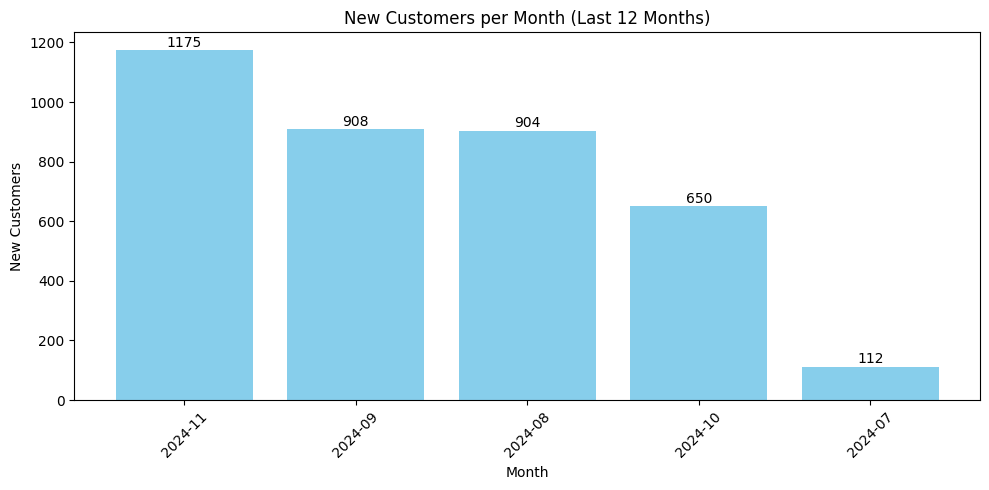

In [5]:
#SQL Code
sql_code_new_customers="""
SELECT
    strftime('%Y-%m', registration_date) AS month_start,
    COUNT(*) AS new_customers
FROM Users
WHERE registration_date >= date('now', '-12 months')
GROUP BY month_start
ORDER BY new_customers desc;"""

#Pandas Code & Visualization
df_users['registration_date'] = pd.to_datetime(df_users['registration_date'])
df_users['month_start'] = df_users['registration_date'].dt.to_period('M').astype(str)
monthly_new = df_users[df_users['registration_date'] >= pd.Timestamp.now() - pd.DateOffset(months=12)]
monthly_counts = monthly_new.groupby('month_start').size().reset_index(name='new_customers')
monthly_counts_sorted = monthly_counts.sort_values('new_customers', ascending=False)
plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_counts_sorted['month_start'], monthly_counts_sorted['new_customers'], color='skyblue')
plt.xticks(rotation=45)
plt.title('New Customers per Month (Last 12 Months)')
plt.xlabel('Month')
plt.ylabel('New Customers')
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)), ha='center', va='bottom')

plt.show()

2.	Active customers: Count of users who made at least one transaction in that month

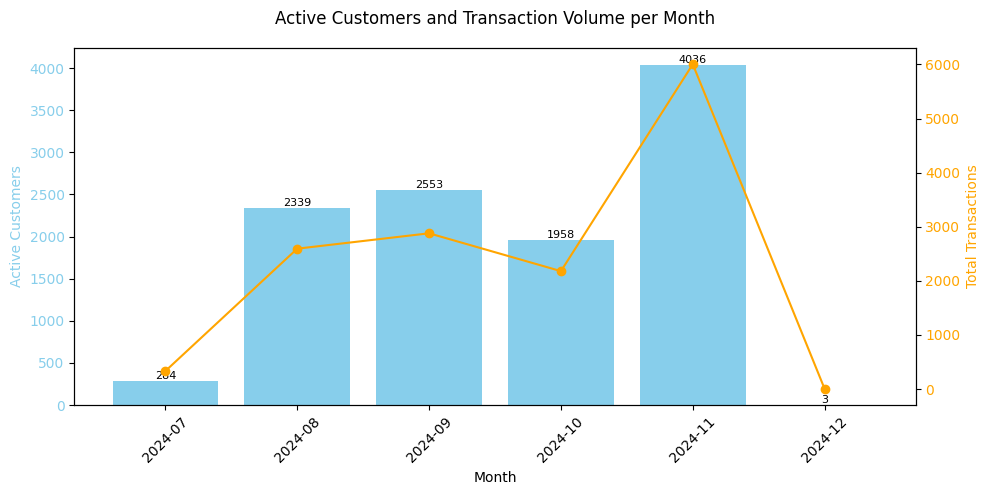

In [6]:
#SQL CODE
sql_code_active_customers="""
SELECT
    strftime('%Y-%m', transaction_date) AS month_start,
    COUNT(DISTINCT user_id) AS active_customers,
    COUNT(*) AS total_transactions
FROM Transactions
WHERE transaction_date >= date('now', '-12 months')
GROUP BY month_start
ORDER BY month_start;"""

#Pandas Code & Visualization
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
df_transactions['month_start'] = df_transactions['transaction_date'].dt.to_period('M').astype(str)

monthly_stats = (
    df_transactions[df_transactions['transaction_date'] >= pd.Timestamp.now() - pd.DateOffset(months=12)]
    .groupby('month_start')
    .agg(
        active_customers=('user_id', pd.Series.nunique),
        total_transactions=('transaction_date', 'count')
    )
    .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))

bars = ax1.bar(monthly_stats['month_start'], monthly_stats['active_customers'], color='skyblue', label='Active Customers')
ax1.set_ylabel('Active Customers', color='skyblue')
ax1.set_xlabel('Month')
ax1.tick_params(axis='y', labelcolor='skyblue')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=8)

ax2 = ax1.twinx()
ax2.plot(monthly_stats['month_start'], monthly_stats['total_transactions'], color='orange', marker='o', label='Total Transactions')
ax2.set_ylabel('Total Transactions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Active Customers and Transaction Volume per Month')
fig.tight_layout()
plt.show()

3.	Transaction volume: Total number of transactions and total transactions amount


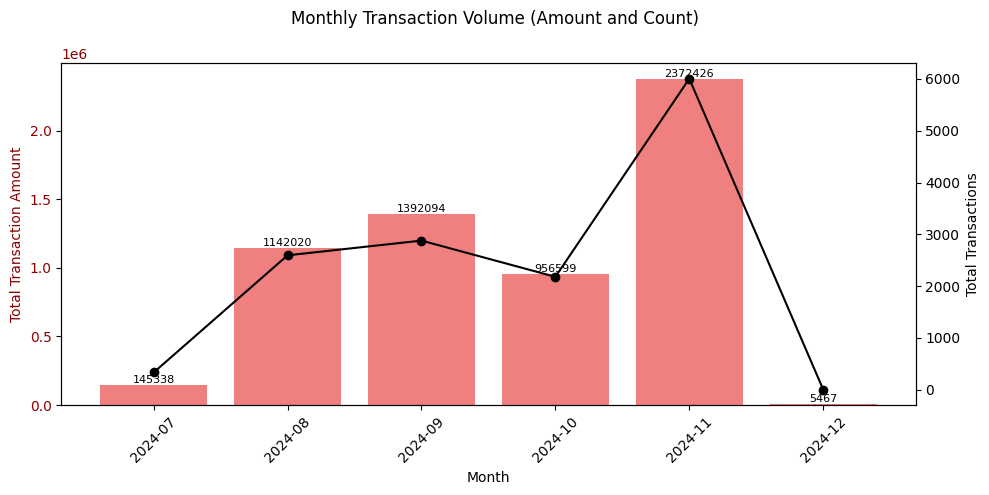

In [7]:
#SQL Code
sql_code_transaction_volume="""
SELECT
    strftime('%Y-%m', transaction_date) AS month_start,
    COUNT(*) AS total_transactions,
    ROUND(SUM(transaction_amount), 2) AS total_transaction_amount
FROM Transactions
WHERE transaction_date >= date('now', '-12 months')
GROUP BY month_start
ORDER BY month_start;"""

#Pandas Code & Visualization

df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
df_transactions['month_start'] = df_transactions['transaction_date'].dt.to_period('M').astype(str)

recent_tx = df_transactions[df_transactions['transaction_date'] >= pd.Timestamp.now() - pd.DateOffset(months=12)]

monthly_volume = (
    recent_tx
    .groupby('month_start')
    .agg(
        total_transactions=('transaction_id', 'count'),
        total_transaction_amount=('transaction_amount', 'sum')
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10, 5))

bars = ax1.bar(monthly_volume['month_start'], monthly_volume['total_transaction_amount'], color='lightcoral', label='Total Amount')
ax1.set_ylabel('Total Transaction Amount', color='darkred')
ax1.set_xlabel('Month')
ax1.tick_params(axis='y', labelcolor='darkred')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.0f}', ha='center', va='bottom', fontsize=8)

ax2 = ax1.twinx()
ax2.plot(monthly_volume['month_start'], monthly_volume['total_transactions'], color='black', marker='o', label='Total Transactions')
ax2.set_ylabel('Total Transactions', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle('Monthly Transaction Volume (Amount and Count)')
fig.tight_layout()
plt.show()

4.	Installment plans: Breakdown of chosen installments_count (4, 6, 12, 24) by volume

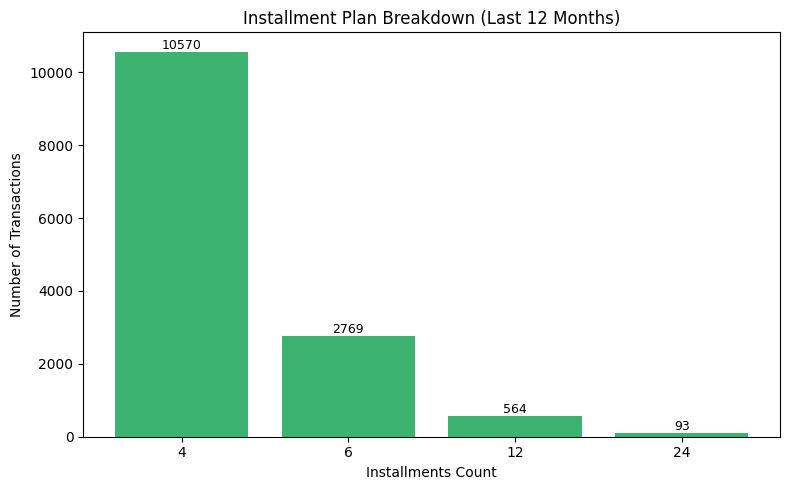

In [8]:
#SQL Code
sql_code_installment_plans="""SELECT
    installments_count,
    COUNT(*) AS installment_plan_count
FROM Transactions
WHERE transaction_date >= date('now', '-12 months')
GROUP BY installments_count
ORDER BY installments_count;"""

#Pandas Code & Visualization

df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
recent_tx = df_transactions[df_transactions['transaction_date'] >= pd.Timestamp.now() - pd.DateOffset(months=12)]

installment_breakdown = (
    recent_tx
    .groupby('installments_count')
    .size()
    .reset_index(name='installment_plan_count')
    .sort_values('installments_count')
)

installment_breakdown['installments_count'] = installment_breakdown['installments_count'].astype(str)

plt.figure(figsize=(8, 5))
bars = plt.bar(installment_breakdown['installments_count'], installment_breakdown['installment_plan_count'], color='mediumseagreen')
plt.xlabel('Installments Count')
plt.ylabel('Number of Transactions')
plt.title('Installment Plan Breakdown (Last 12 Months)')
plt.xticks(rotation=0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

5.	Popular categories: Top merchant categories by transaction count

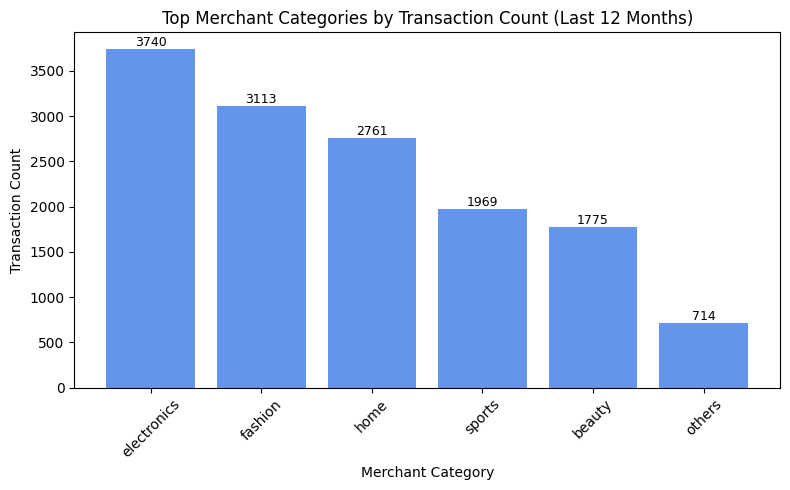

In [9]:
#SQL Code

sql_code_top_merchants="""
SELECT
    m.category,
    COUNT(*) AS transaction_count
FROM Transactions t
LEFT JOIN Merchants m ON t.merchant_id = m.merchant_id
WHERE t.transaction_date >= date('now', '-12 months')
GROUP BY m.category
ORDER BY transaction_count DESC;"""

#Pandas Code & Visualization

category_counts = pd.read_sql_query(sql_code_top_merchants, conn)

plt.figure(figsize=(8, 5))
bars = plt.bar(category_counts['category'], category_counts['transaction_count'], color='cornflowerblue')
plt.xlabel('Merchant Category')
plt.ylabel('Transaction Count')
plt.title('Top Merchant Categories by Transaction Count (Last 12 Months)')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

2.	Payment Analysis

1.	Define DPD(days past due) aggregate on transaction level

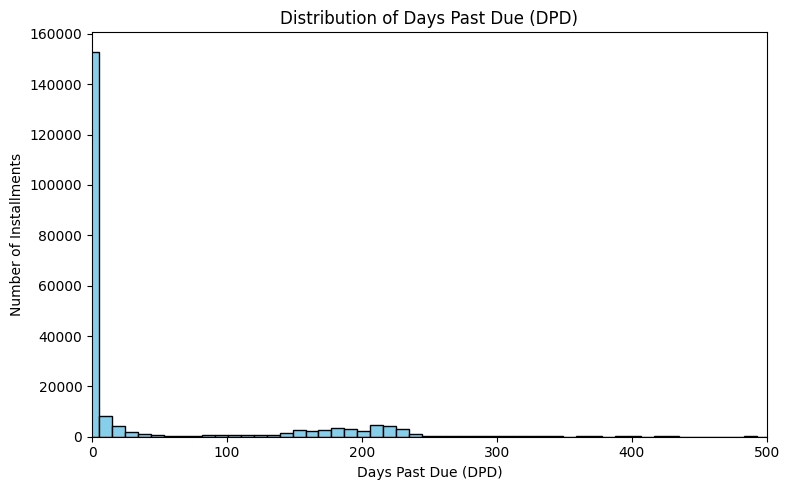

Percentage of installments paid on time: 19.15%
Installments with DPD 1–5 days: 111646 out of 214828 (51.97%)
Installments with DPD ≥ 90 days: 41664 out of 214828 (19.39%)


In [10]:
#SQL Code
sql_code_dpd="""
SELECT
    installment_id,
    transaction_id,
    scheduled_date,
    payment_date,
    CASE
        WHEN payment_date IS NULL THEN julianday('now') - julianday(scheduled_date)
        WHEN julianday(payment_date) > julianday(scheduled_date) THEN julianday(payment_date) - julianday(scheduled_date)
        ELSE 0
    END AS dpd
FROM Installments;"""

dpd_view = pd.read_sql_query(sql_code_dpd, conn)

plt.figure(figsize=(8, 5))
plt.hist(dpd_view['dpd'], bins=3000, color='skyblue', edgecolor='black')
plt.xlabel('Days Past Due (DPD)')
plt.ylabel('Number of Installments')
plt.title('Distribution of Days Past Due (DPD)')
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

on_time = (dpd_view['dpd'] == 0).sum()
total = len(dpd_view)
percentage_on_time = round((on_time / total) * 100, 2)
print(f"Percentage of installments paid on time: {percentage_on_time}%")


dpd_1_to_5 = ((dpd_view['dpd'] >= 1) & (dpd_view['dpd'] <= 5)).sum()
percentage_1_to_5 = round((dpd_1_to_5 / total) * 100, 2)
print(f"Installments with DPD 1–5 days: {dpd_1_to_5} out of {total} ({percentage_1_to_5}%)")


dpd_90_plus = (dpd_view['dpd'] >= 90).sum()
percentage_90_plus = round((dpd_90_plus / total) * 100, 2)
print(f"Installments with DPD ≥ 90 days: {dpd_90_plus} out of {total} ({percentage_90_plus}%)")

2.	Define DPD90 rate. For each transaction

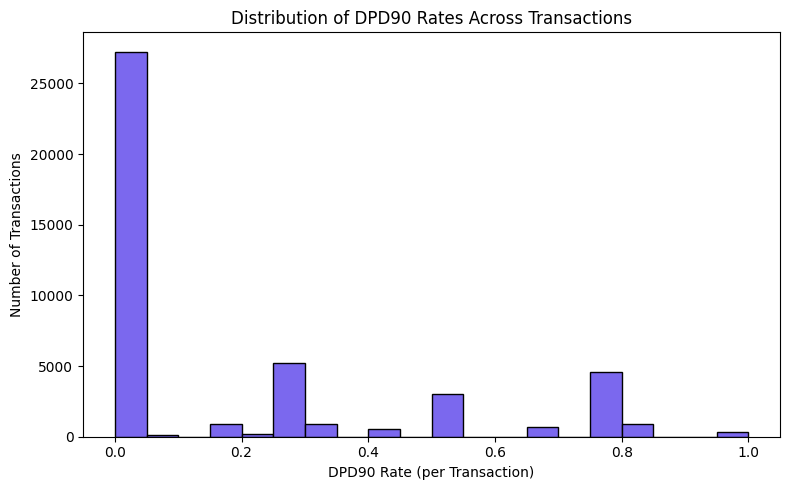

Average DPD90 rate across all transactions: 0.191


In [11]:
sql_code_dpd90="""
SELECT
    transaction_id,
    COUNT(*) AS total_installments,
    SUM(
        CASE
            WHEN
                (payment_date IS NULL AND julianday('now') - julianday(scheduled_date) >= 90) OR
                (payment_date IS NOT NULL AND julianday(payment_date) - julianday(scheduled_date) >= 90)
            THEN 1
            ELSE 0
        END
    ) AS dpd90_count,
    ROUND(
        1.0 * SUM(
            CASE
                WHEN
                    (payment_date IS NULL AND julianday('now') - julianday(scheduled_date) >= 90) OR
                    (payment_date IS NOT NULL AND julianday(payment_date) - julianday(scheduled_date) >= 90)
                THEN 1
                ELSE 0
            END
        ) / COUNT(*), 3
    ) AS dpd90_rate
FROM Installments
GROUP BY transaction_id
ORDER BY dpd90_rate DESC;"""

dpd_90 = pd.read_sql_query(sql_code_dpd90, conn)

plt.figure(figsize=(8, 5))
plt.hist(dpd_90['dpd90_rate'], bins=20, color='mediumslateblue', edgecolor='black')
plt.xlabel('DPD90 Rate (per Transaction)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of DPD90 Rates Across Transactions')
plt.tight_layout()
plt.show()

average_dpd90_rate = round(dpd_90['dpd90_rate'].mean(), 3)
print(f"Average DPD90 rate across all transactions: {average_dpd90_rate}")


3.	Calculate DPD90 rates. Show what % of transactions have DPD90 = 1 for:
<br>a.	By age groups (18-25, 26-35, 36-50, 51+)
<br>b.	By income ranges (0-15k, 15k-30k, 30k-60k, 60k+)
<br>c.	By transaction month (2023-01, 2023-02,...)


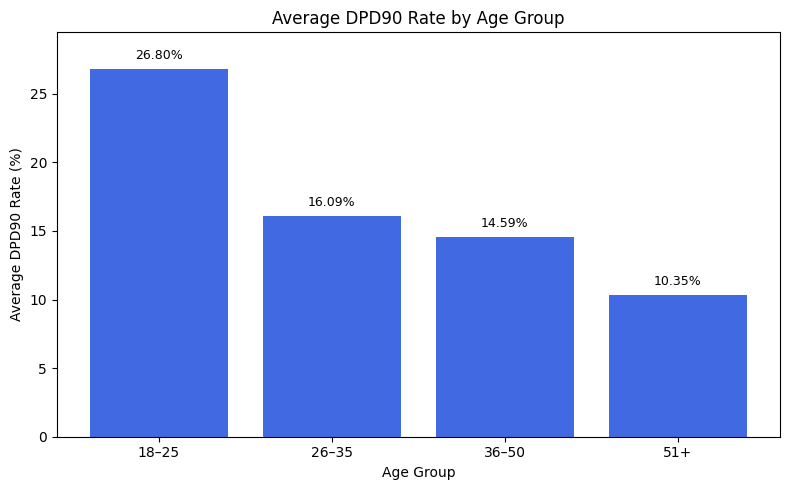

In [12]:
#AGE GROUPS ANALYSIS
sql_dpd_age_groups = """WITH installment_dpd AS (
    SELECT
        transaction_id,
        CASE 
            WHEN 
                CASE
                    WHEN payment_date IS NULL THEN julianday('now') - julianday(scheduled_date)
                    WHEN julianday(payment_date) > julianday(scheduled_date) THEN julianday(payment_date) - julianday(scheduled_date)
                    ELSE 0
                END >= 90
            THEN 1
            ELSE 0
        END AS dpd_90
    FROM Installments
),
transaction_dpd90_rate AS (
    SELECT
        transaction_id,
        1.0 * SUM(dpd_90) / COUNT(*) AS dpd90_rate
    FROM installment_dpd
    GROUP BY transaction_id
),
transaction_with_age AS (
    SELECT
        tdr.transaction_id,
        tdr.dpd90_rate,
        u.age
    FROM transaction_dpd90_rate tdr
    LEFT JOIN Transactions t ON tdr.transaction_id = t.transaction_id
    LEFT JOIN Users u ON t.user_id = u.user_id
)
SELECT
    CASE
        WHEN age BETWEEN 18 AND 25 THEN '18–25'
        WHEN age BETWEEN 26 AND 35 THEN '26–35'
        WHEN age BETWEEN 36 AND 50 THEN '36–50'
        ELSE '51+'
    END AS age_group,
    ROUND(AVG(dpd90_rate) * 100, 2) AS avg_dpd90_rate_percent,
    COUNT(*) AS transaction_count
FROM transaction_with_age
GROUP BY age_group
ORDER BY age_group;
"""


dpd_90_age_groups = pd.read_sql_query(sql_dpd_age_groups, conn)

plt.figure(figsize=(8, 5))
bars = plt.bar(dpd_90_age_groups['age_group'], dpd_90_age_groups['avg_dpd90_rate_percent'], color='royalblue')
plt.xlabel('Age Group')
plt.ylabel('Average DPD90 Rate (%)')
plt.title('Average DPD90 Rate by Age Group')
plt.ylim(0, dpd_90_age_groups['avg_dpd90_rate_percent'].max() * 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


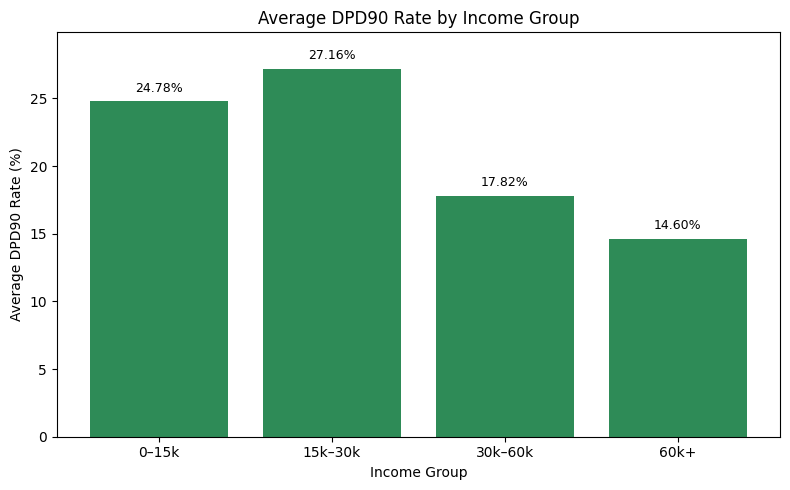

In [13]:
#INCOME RANGE NALYSIS

sql_code_dpd_income_ranges = """WITH installment_dpd AS (
    SELECT
        transaction_id,
        CASE 
            WHEN 
                CASE
                    WHEN payment_date IS NULL THEN julianday('now') - julianday(scheduled_date)
                    WHEN julianday(payment_date) > julianday(scheduled_date) THEN julianday(payment_date) - julianday(scheduled_date)
                    ELSE 0
                END >= 90
            THEN 1
            ELSE 0
        END AS dpd_90
    FROM Installments
),
transaction_dpd90_rate AS (
    SELECT
        transaction_id,
        1.0 * SUM(dpd_90) / COUNT(*) AS dpd90_rate
    FROM installment_dpd
    GROUP BY transaction_id
),
transaction_with_income AS (
    SELECT
        tdr.transaction_id,
        tdr.dpd90_rate,
        u.income
    FROM transaction_dpd90_rate tdr
    LEFT JOIN Transactions t ON tdr.transaction_id = t.transaction_id
    LEFT JOIN Users u ON t.user_id = u.user_id
)
SELECT
    CASE
        WHEN income < 15000 THEN '0–15k'
        WHEN income < 30000 THEN '15k–30k'
        WHEN income < 60000 THEN '30k–60k'
        ELSE '60k+'
    END AS income_group,
    ROUND(AVG(dpd90_rate) * 100, 2) AS avg_dpd90_rate_percent,
    COUNT(*) AS transaction_count
FROM transaction_with_income
GROUP BY income_group
ORDER BY income_group;
"""

dpd_90_income_range = pd.read_sql_query(sql_code_dpd_income_ranges, conn)


plt.figure(figsize=(8, 5))
bars = plt.bar(dpd_90_income_range['income_group'], dpd_90_income_range['avg_dpd90_rate_percent'], color='seagreen')
plt.xlabel('Income Group')
plt.ylabel('Average DPD90 Rate (%)')
plt.title('Average DPD90 Rate by Income Group')
plt.ylim(0, dpd_90_income_range['avg_dpd90_rate_percent'].max() * 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

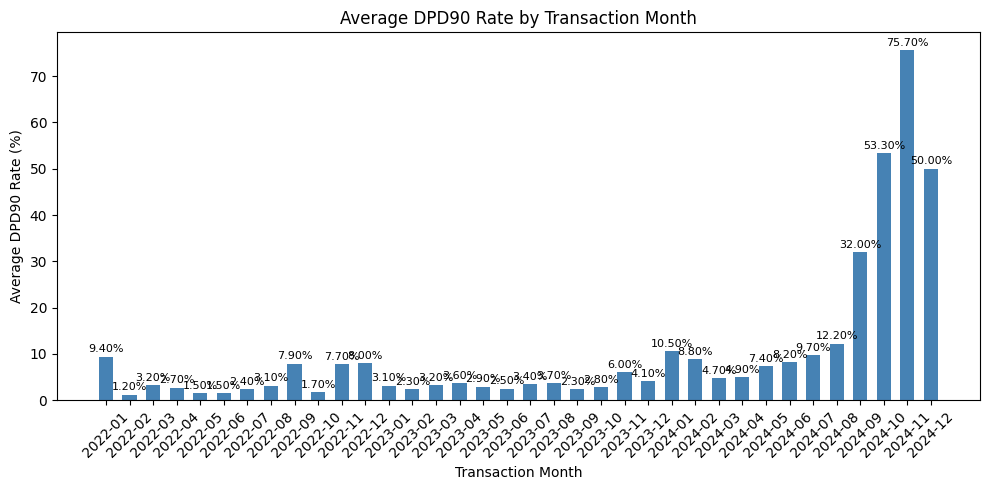

In [14]:
# TRANSACTION MONTH ANALYSIS

sql_code_dpd_transaction_month = """WITH installment_dpd AS (
    SELECT
        i.transaction_id,
        CASE 
            WHEN 
                CASE
                    WHEN i.payment_date IS NULL THEN julianday('now') - julianday(i.scheduled_date)
                    WHEN julianday(i.payment_date) > julianday(i.scheduled_date) THEN julianday(i.payment_date) - julianday(i.scheduled_date)
                    ELSE 0
                END >= 90
            THEN 1
            ELSE 0
        END AS dpd_90
    FROM Installments i
), transaction_dpd90_rate AS (
    SELECT
        transaction_id,
        AVG(dpd_90) AS dpd90_rate
    FROM installment_dpd
    GROUP BY transaction_id
) SELECT
    strftime('%Y-%m', t.transaction_date) AS transaction_month,
    ROUND(AVG(tdr.dpd90_rate) * 100, 1) AS avg_dpd90_rate_percent,
    COUNT(*) AS transaction_count
FROM transaction_dpd90_rate tdr
LEFT JOIN Transactions t ON tdr.transaction_id = t.transaction_id
GROUP BY transaction_month
ORDER BY transaction_month;
"""

dpd_transaction_month = pd.read_sql_query(sql_code_dpd_transaction_month, conn)

x = list(range(len(dpd_transaction_month)))
heights = dpd_transaction_month['avg_dpd90_rate_percent']
labels = dpd_transaction_month['transaction_month']

plt.figure(figsize=(10, 5))
bars = plt.bar(x, heights, width=0.6, color='steelblue')
plt.xlabel('Transaction Month')
plt.ylabel('Average DPD90 Rate (%)')
plt.title('Average DPD90 Rate by Transaction Month')
plt.xticks(x, labels, rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

3.	Vintage Analysis

1.	Group customers by the month of their first transaction
<br>
2.	Calculate per every first transaction if they reach DPD90 status after 1,2,3..n month

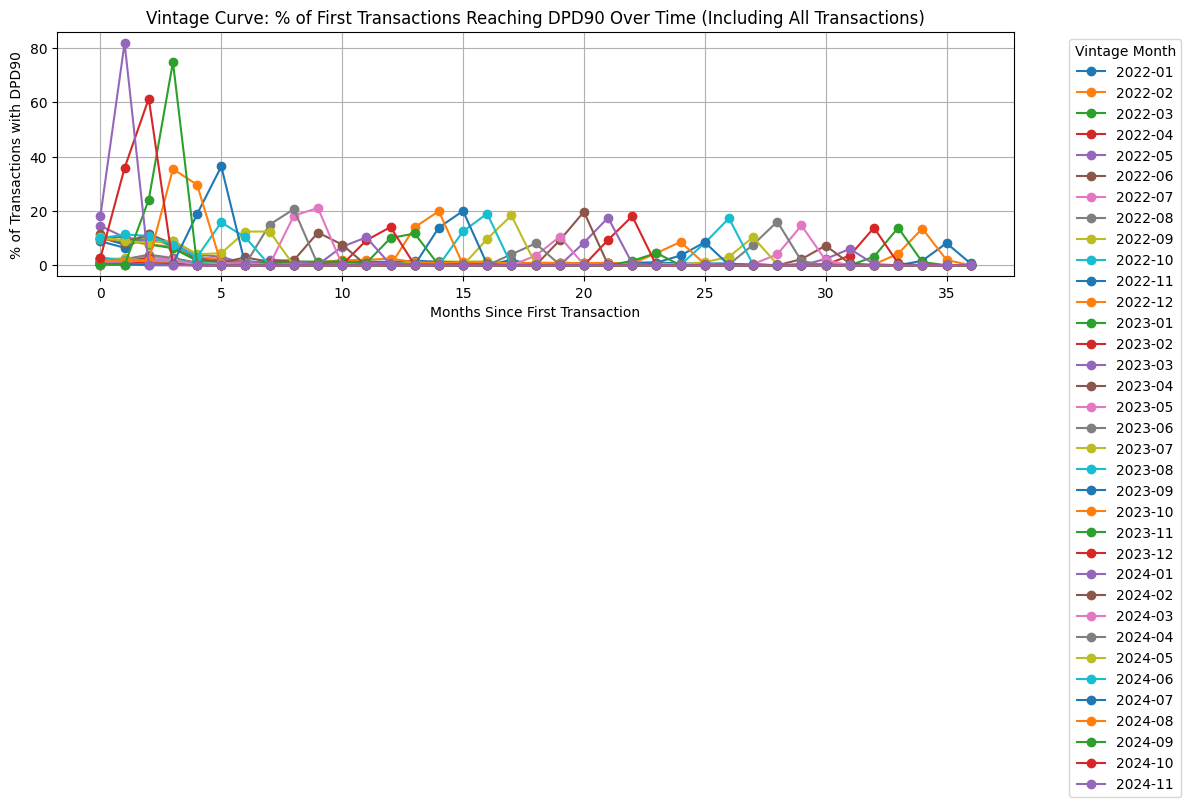

In [15]:
sql_query_dpd_90_months="""
WITH installment_dpd AS (
    SELECT
        t.transaction_id,
        t.user_id,
        t.transaction_date,
        i.scheduled_date,
        i.payment_date,
        CASE
            WHEN i.payment_date IS NULL THEN julianday('now') - julianday(i.scheduled_date)
            WHEN julianday(i.payment_date) > julianday(i.scheduled_date) THEN julianday(i.payment_date) - julianday(i.scheduled_date)
            ELSE 0
        END AS dpd,
        CASE
            WHEN 
                CASE
                    WHEN i.payment_date IS NULL THEN julianday('now') - julianday(i.scheduled_date)
                    WHEN julianday(i.payment_date) > julianday(i.scheduled_date) THEN julianday(i.payment_date) - julianday(i.scheduled_date)
                    ELSE 0
                END >= 90 THEN 1
            ELSE 0
        END AS dpd90
    FROM Installments i
    LEFT JOIN Transactions t ON i.transaction_id = t.transaction_id
),
first_transaction_per_user AS (
    SELECT user_id, transaction_id, MIN(transaction_date) AS first_transaction_date
    FROM installment_dpd
    GROUP BY user_id
),
first_dpd90_event AS (
    SELECT
        i.user_id,
        MIN(i.scheduled_date) AS first_dpd90_scheduled_date
    FROM installment_dpd i
    WHERE i.dpd90 = 1
    GROUP BY i.user_id
)
SELECT
    f.user_id,
    f.transaction_id,
    f.first_transaction_date,
    CASE WHEN d.first_dpd90_scheduled_date IS NOT NULL THEN 1 ELSE 0 END AS dpd_status,
    CASE 
        WHEN d.first_dpd90_scheduled_date IS NOT NULL THEN 
            CAST((julianday(d.first_dpd90_scheduled_date) - julianday(f.first_transaction_date)) / 30.0 AS INT)
        ELSE NULL
    END AS n_months
FROM first_transaction_per_user f
LEFT JOIN first_dpd90_event d ON f.user_id = d.user_id;
"""

dpd_90_months = pd.read_sql_query(sql_query_dpd_90_months, conn)

dpd_90_months['vintage_month'] = pd.to_datetime(dpd_90_months['first_transaction_date']).dt.to_period('M')

dpd90_users = dpd_90_months[(dpd_90_months['dpd_status'] == 1) & (dpd_90_months['n_months'].notnull())]


dpd_counts = dpd90_users.groupby(['vintage_month', 'n_months'])['transaction_id'].count().reset_index()
dpd_counts.rename(columns={'transaction_id': 'dpd90_transactions'}, inplace=True)


total_users = dpd_90_months.groupby('vintage_month')['transaction_id'].nunique().reset_index()
total_users.rename(columns={'transaction_id': 'total_transactions'}, inplace=True)


vintage_curve = dpd_counts.merge(total_users, on='vintage_month')
vintage_curve['dpd90_rate'] = (vintage_curve['dpd90_transactions'] / vintage_curve['total_transactions']) * 100


pivot = vintage_curve.pivot(index='n_months', columns='vintage_month', values='dpd90_rate').fillna(0)


plt.figure(figsize=(12, 6))
for column in pivot.columns:
    plt.plot(pivot.index, pivot[column], marker='o', label=str(column))

plt.title('Vintage Curve: % of First Transactions Reaching DPD90 Over Time (Including All Transactions)')
plt.xlabel('Months Since First Transaction')
plt.ylabel('% of Transactions with DPD90')
plt.legend(title='Vintage Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def plot_vintage_at_n_months(n_months):
    plt.figure(figsize=(12, 6))
    if n_months in pivot.index:
        y = pivot.loc[n_months]
        plt.plot(pivot.columns.astype(str), y, marker='o')
        plt.title(f'Vintage Curve: % of First Transactions Reaching DPD90 at {int(n_months)} Months')
        plt.xlabel('Vintage Month')
        plt.ylabel('% of Transactions with DPD90')
        plt.xticks(rotation=45)
        plt.grid(True)
    else:
        plt.title('No data for selected n_months')
    plt.tight_layout()
    plt.show()

n_months_slider = widgets.IntSlider(
    value=int(pivot.index.min()),
    min=int(pivot.index.min()),
    max=int(pivot.index.max()),
    step=1,
    description='n_months:',
    continuous_update=False
)

widgets.interact(plot_vintage_at_n_months, n_months=n_months_slider)
